# opsZero Network Architecture

## Deployment Pipeline

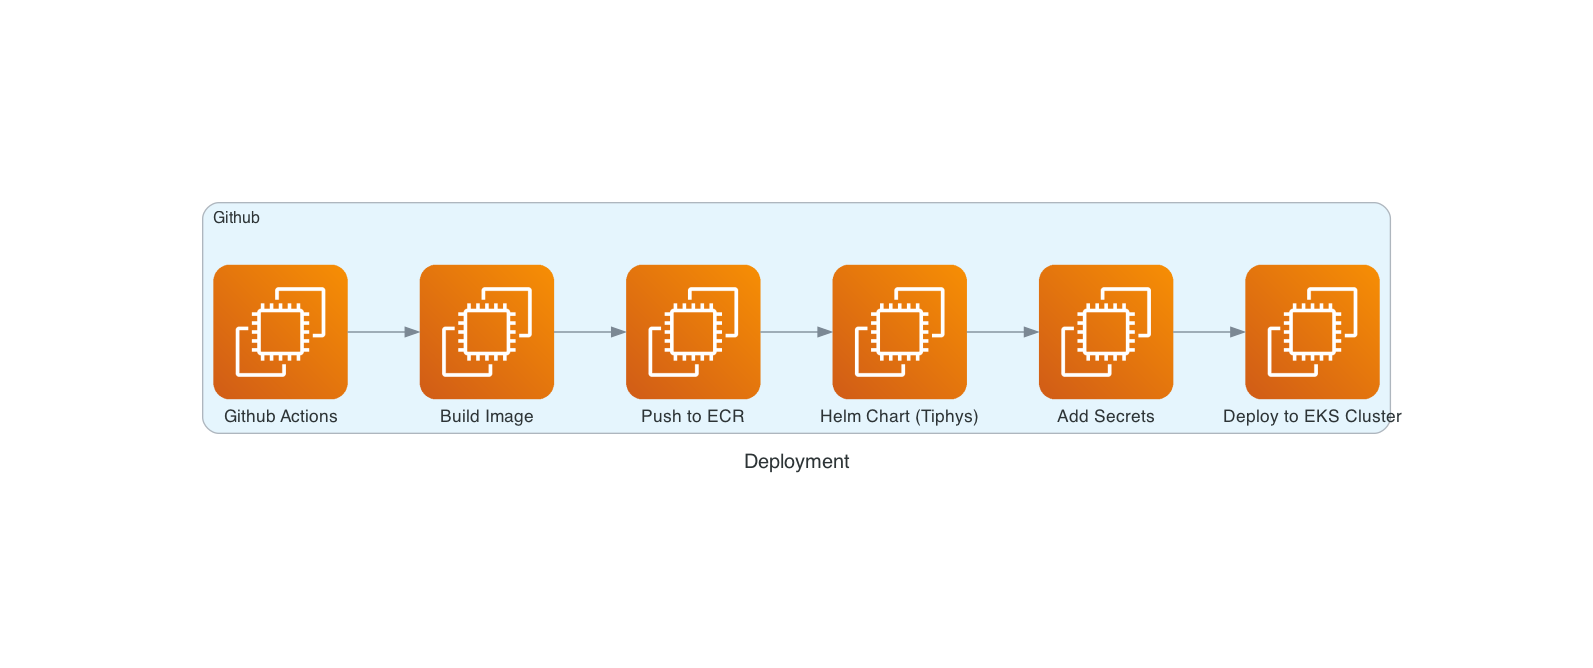

In [2]:
import warnings
warnings.filterwarnings('ignore')

from diagrams import Diagram, Cluster
from diagrams.aws.compute import EC2

with Diagram("Deployment", show=False, direction="LR") as diag:
    with Cluster("Github"):
        EC2("Github Actions") >> EC2("Build Image") >> EC2("Push to ECR") >> EC2("Helm Chart (Tiphys)") >> EC2("Add Secrets") >> EC2("Deploy to EKS Cluster")

diag


# AWS Cloud Infrastructure

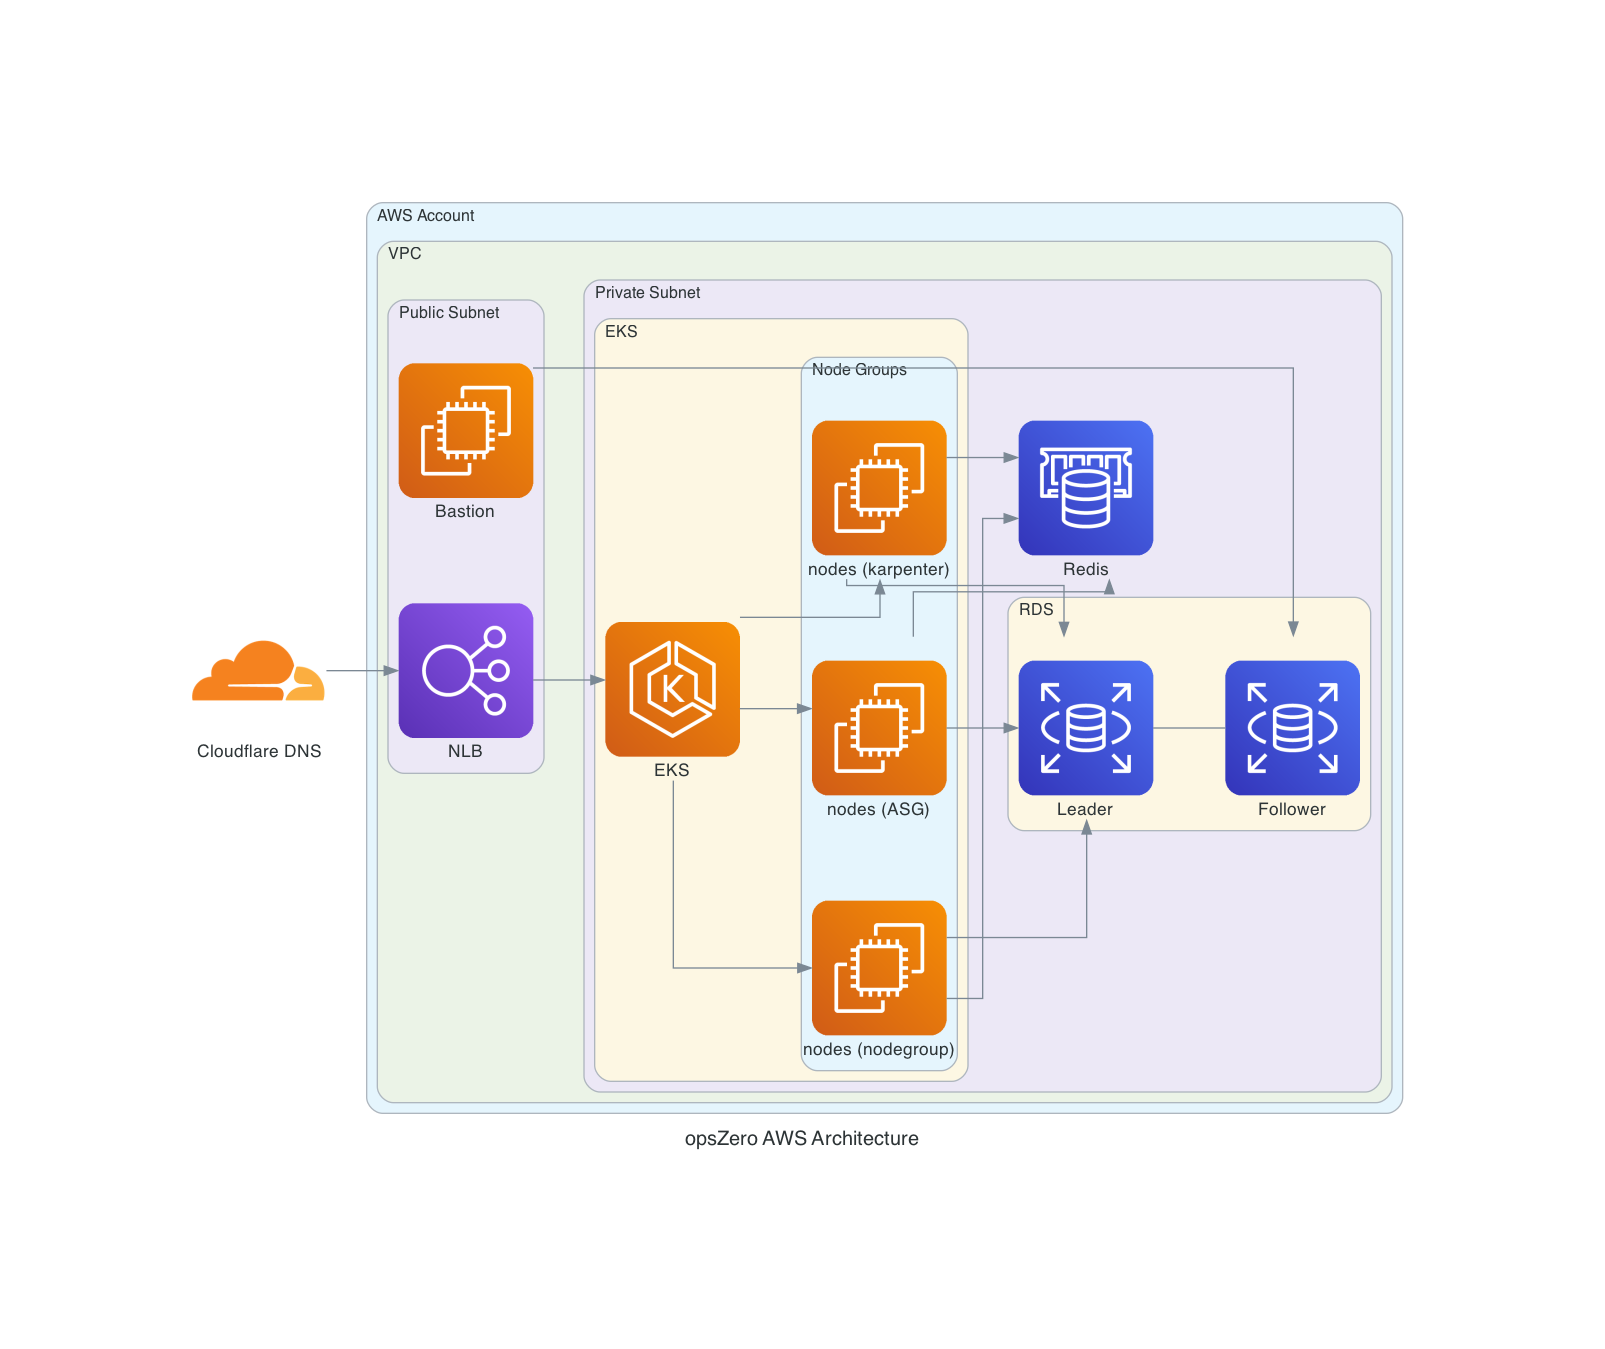

In [5]:
from diagrams import Cluster, Diagram
from diagrams.aws.database import RDS, ElastiCache
from diagrams.aws.network import ELB
from diagrams.aws.compute import EC2, ElasticKubernetesService
from diagrams.saas.cdn import Cloudflare

with Diagram("opsZero AWS Architecture", show=False) as diag:

    dns = Cloudflare("Cloudflare DNS")\

    with Cluster("AWS Account"):
        with Cluster("VPC"):
            with Cluster("Public Subnet"):
                lb = ELB("NLB")

                bastion = EC2("Bastion")

            with Cluster("Private Subnet"):
                with Cluster("EKS"):
                    eks = ElasticKubernetesService("EKS")
                    with Cluster("Node Groups"):
                        svc_group = [
                            EC2("nodes (nodegroup)"),
                            EC2("nodes (karpenter)"),
                            EC2("nodes (ASG)")
                        ]

                with Cluster("RDS"):
                    db_master = RDS("Leader")
                    db_follower = RDS("Follower")
                    db_master - [db_follower]

                redis = ElastiCache("Redis")

    

    dns >> lb >> eks >> svc_group
    bastion >> db_follower
    svc_group >> db_master
    svc_group >> redis

diag

## Kubernetes

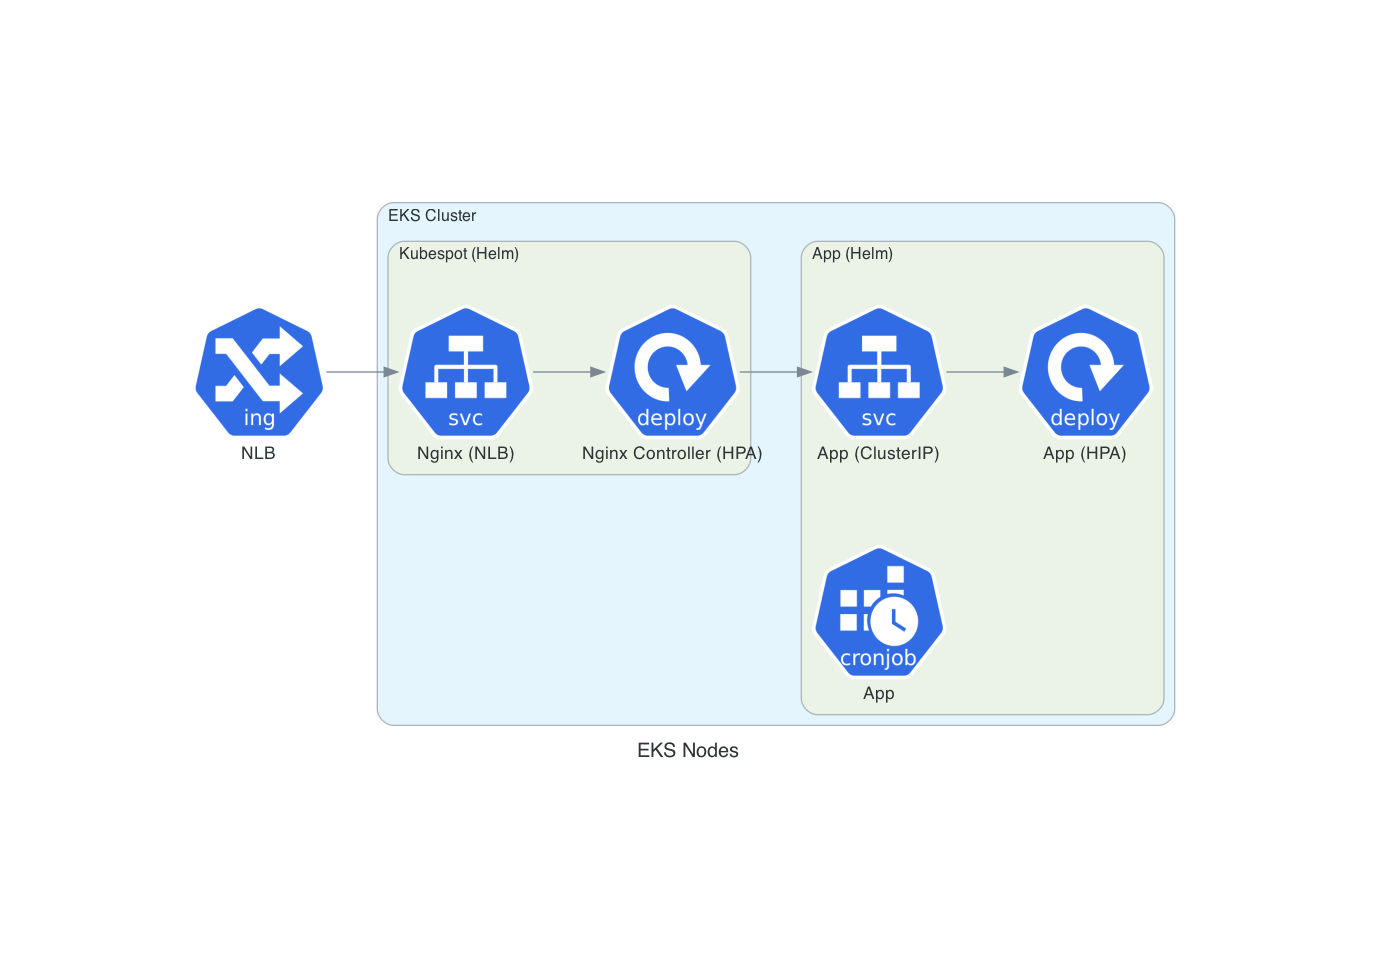

In [10]:
from diagrams import Cluster, Diagram
from diagrams.k8s.clusterconfig import HPA
from diagrams.k8s.compute import Deployment, Pod, ReplicaSet, Cronjob
from diagrams.k8s.network import Ingress, Service

with Diagram("EKS Nodes", show=False) as diag:
    nlb = Ingress("NLB")
    with Cluster("EKS Cluster"):
        with Cluster("Kubespot (Helm)"):
            net = nlb >> Service("Nginx (NLB)") >> Deployment("Nginx Controller (HPA)")

        with Cluster("App (Helm)"):
            net >> Service("App (ClusterIP)") >> [
                Deployment("App (HPA)"),
            ]
            Cronjob("App")

diag

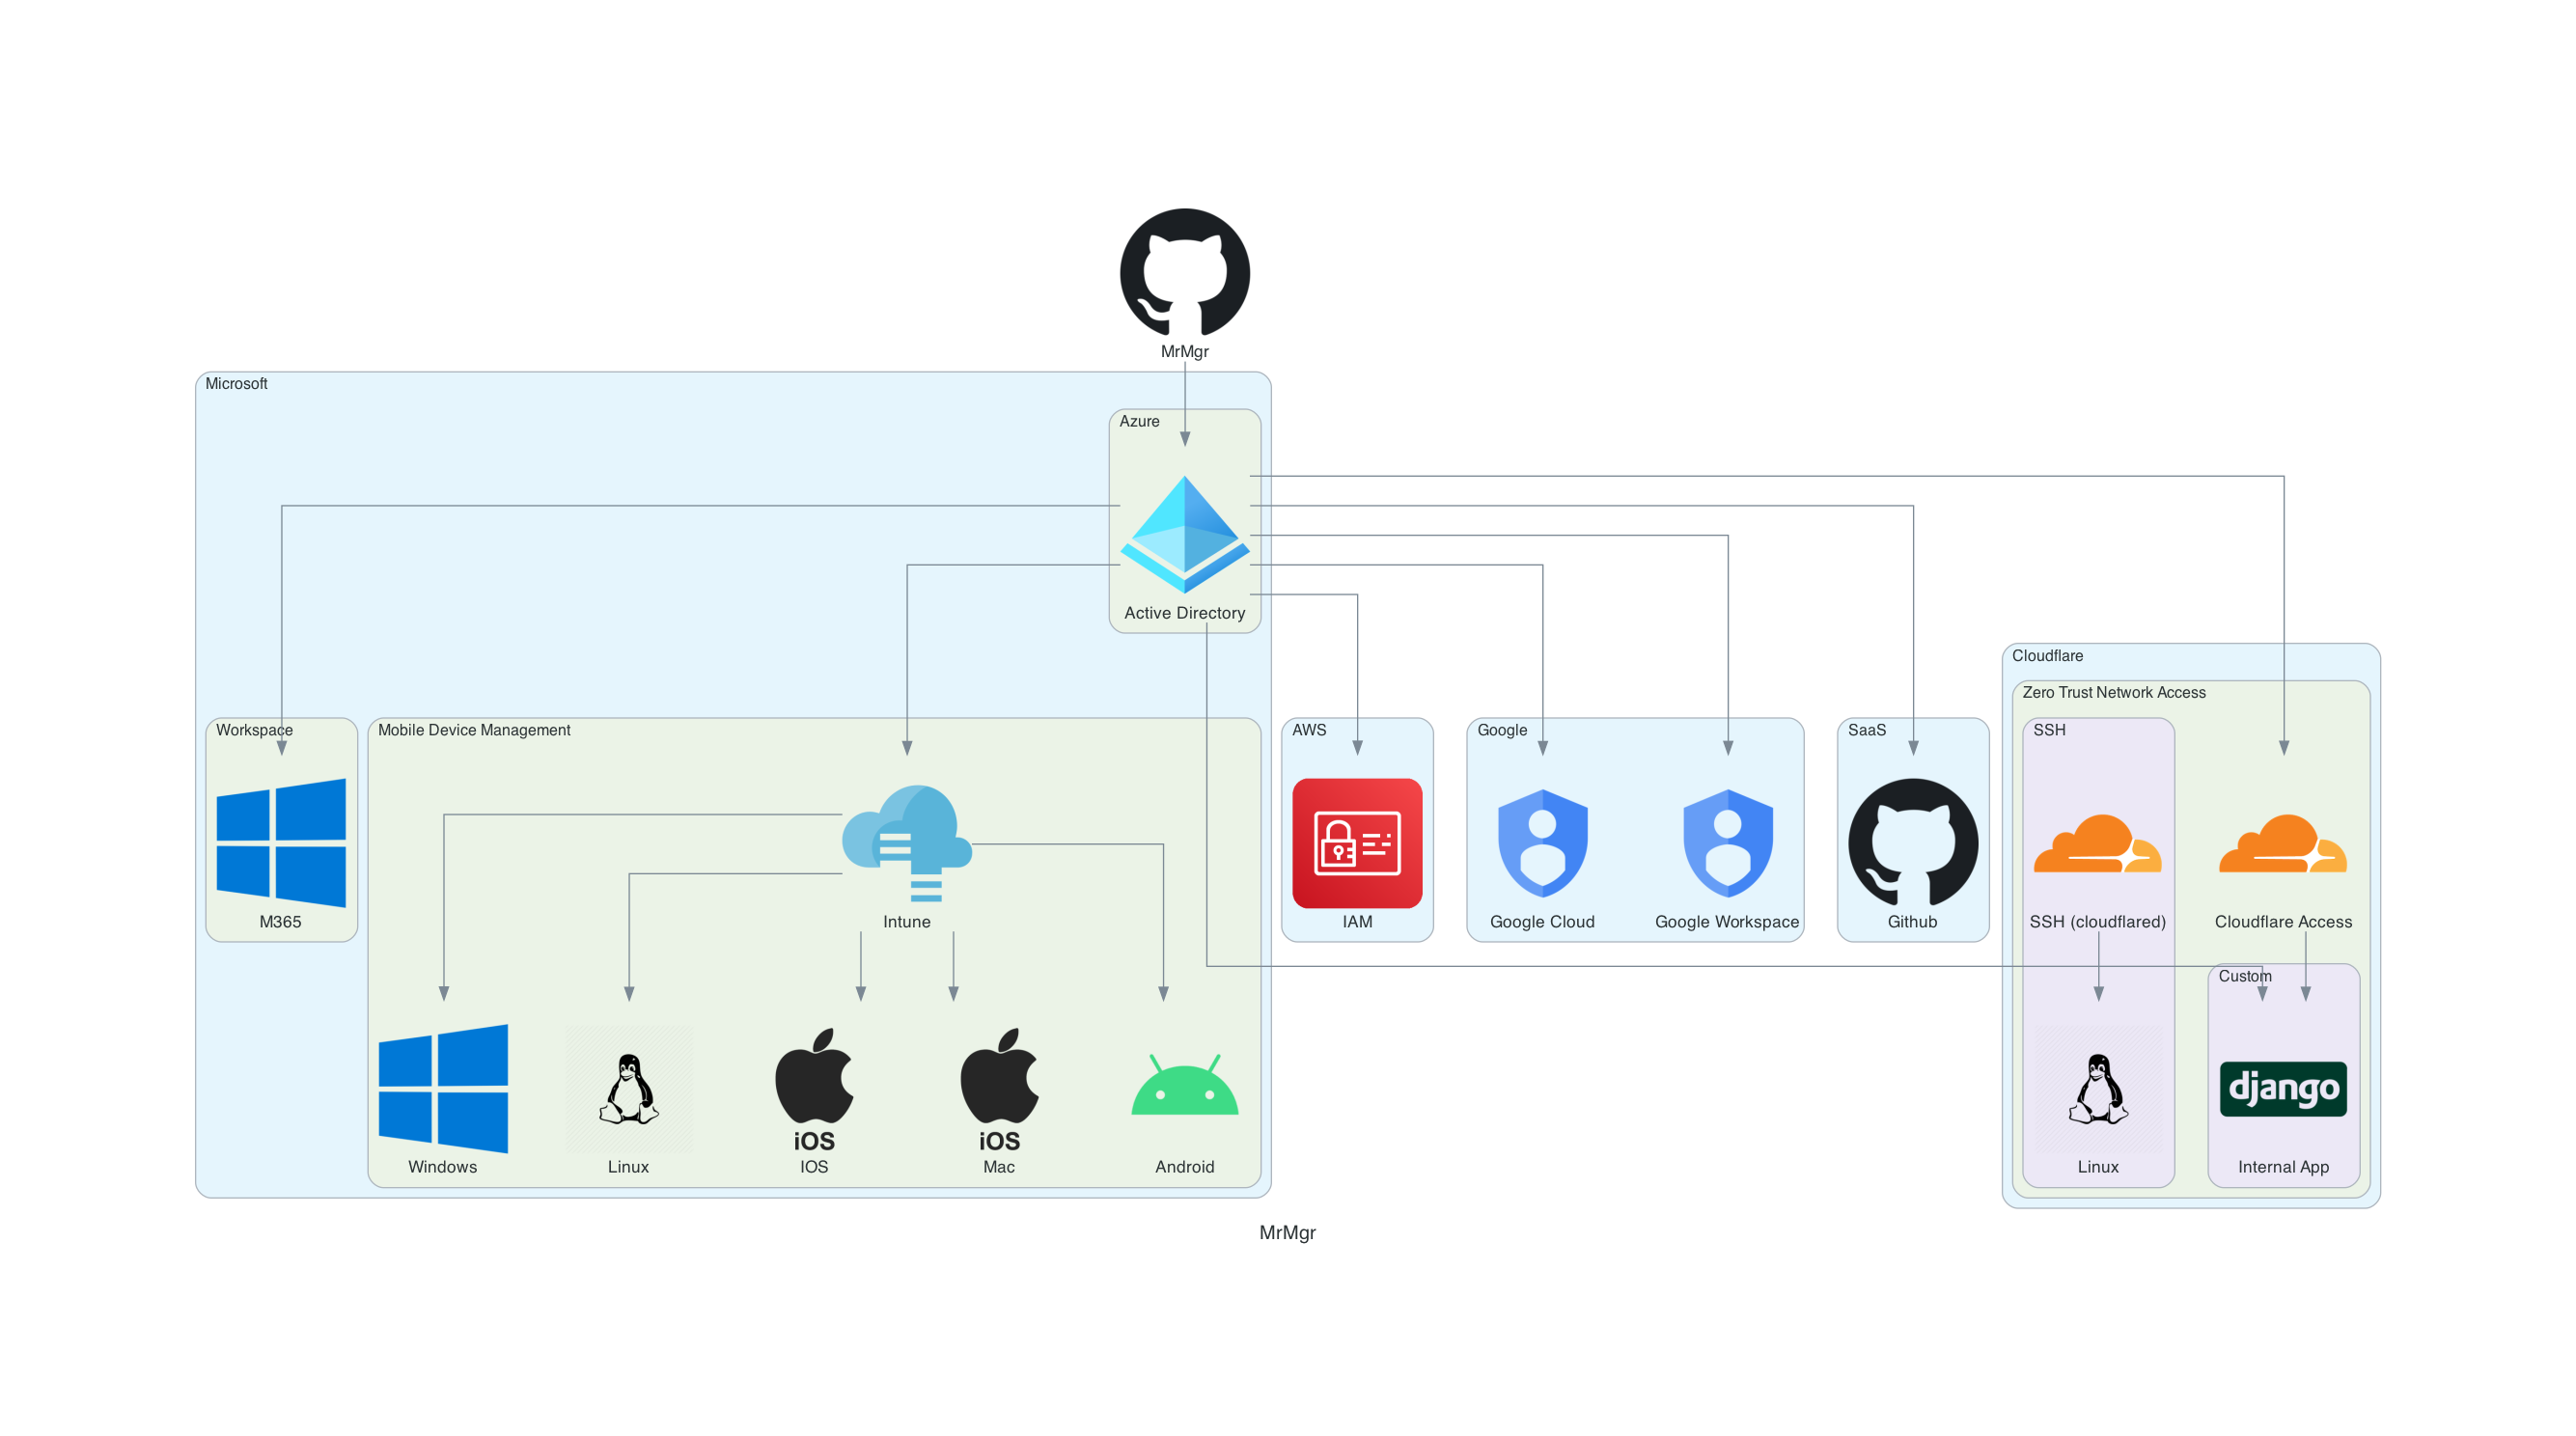

In [42]:
from diagrams.azure.identity import ActiveDirectory
from diagrams.onprem.vcs import Github
from diagrams.azure.integration import StorsimpleDeviceManagers
from diagrams.saas.cdn import Cloudflare
from diagrams.generic.os import LinuxGeneral
from diagrams.generic.os import IOS
from diagrams.generic.os import Android
from diagrams.generic.os import Windows
from diagrams.aws.security import IdentityAndAccessManagementIam
from diagrams.programming.framework import Django
from diagrams.gcp.security import Iam
from diagrams.saas.chat import Teams


with Diagram("MrMgr", show=False, direction="TB") as diag:
    mrmgr = Github("MrMgr")


    with Cluster("Microsoft"):
        with Cluster("Azure"):
            active_directory = ActiveDirectory("Active Directory")
            mrmgr >> active_directory

        with Cluster("Workspace"):
            active_directory >> Windows("M365")

        with Cluster("Mobile Device Management"):
            active_directory >> StorsimpleDeviceManagers("Intune") >> [
                Windows("Windows"),
                LinuxGeneral("Linux"),
                IOS("IOS"),
                IOS("Mac"),
                Android("Android"),
            ]

    with Cluster("AWS"):
        active_directory >> IdentityAndAccessManagementIam("IAM")

    with Cluster("Google"):
        active_directory >> [
            Iam("Google Workspace"),
            Iam("Google Cloud"),
        ]

    with Cluster("SaaS"):
        active_directory >> Github("Github")

    with Cluster("Cloudflare"):
        with Cluster("Zero Trust Network Access"):
            access = Cloudflare("Cloudflare Access")
            active_directory >> access
            with Cluster("SSH"):
                Cloudflare("SSH (cloudflared)") >> LinuxGeneral("Linux")


            with Cluster("Custom"):
                app = Django("Internal App")
                active_directory >> app
                access >> app

diag

